In [0]:
!wget https://crisisnlp.qcri.org/data/ASONAM17_damage_images/ASONAM17_Damage_Image_Dataset.tar.gz

--2019-12-01 19:22:49--  https://crisisnlp.qcri.org/data/ASONAM17_damage_images/ASONAM17_Damage_Image_Dataset.tar.gz
Resolving crisisnlp.qcri.org (crisisnlp.qcri.org)... 80.76.166.234
Connecting to crisisnlp.qcri.org (crisisnlp.qcri.org)|80.76.166.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4555678900 (4.2G) [application/x-gzip]
Saving to: ‘ASONAM17_Damage_Image_Dataset.tar.gz.1’

ASONAM17_Damage_Ima 100%[===================>]   4.24G  11.1MB/s    in 7m 56s  

2019-12-01 19:30:46 (9.14 MB/s) - ‘ASONAM17_Damage_Image_Dataset.tar.gz.1’ saved [4555678900/4555678900]



In [0]:
!tar -xf ASONAM17_Damage_Image_Dataset.tar.gz

In [0]:
import numpy as np
import pandas as pd
!pip install tensorflow-gpu==2.0.0  as tf
from PIL import Image
import glob
import tensorflow as tf
from tensorflow.keras import Sequential
from PIL import Image
import glob
import matplotlib.pyplot as plt

In [0]:
# Converts a csv file to a training and validation dataset. The validation set is 20% of the entire dataset.
def convert_to_train_and_validation(csv_file_name, training_set_name, validation_set_name):
  # Reads a csv file and creates a panda dataframe
  dataFrame = pd.read_csv(csv_file_name);
  # Samples the dataframe and pulls out 20% of the values and creates another dataset which is later used as the validation set
 # rows = dataFrame.sample(frac=0.20)
  
  index = []
  for i in range(len(dataFrame)):
    index.append(dataFrame.index[i])

  # Drops the index from the results of the csv file
  dfObj = dataFrame.drop(index = index, axis = 0)

  # Creates a training and a validation dataset
  dataFrame.to_csv(training_set_name, index = False)
  #dfObj.to_csv(validation_set_name, index = False)
  # Returns the dataframe object
  return dfObj;

# Creating a list of headers to append to the datasets since the csv file does not come with headers. 
# The headers are f0, f1, f2 .... 
def CreateHeaders(dataFrame):
  headers = []
  for x in range(len(dataFrame.columns)):
    headers.append("f"+ str(x))
  return headers

def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=5, # Artificially small to make examples easier to show.
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      **kwargs)
  dataset.shuffle(1000).batch(5)
  dataset.repeat(100000).batch(1)
  return dataset


def Create_Training_and_Labels(file_name):
  df=pd.read_csv(file_name, sep=',',header=None)
  train_values = np.array([])
  labels = np.array([])
  for i in df.values:
    train_values = np.append(train_values, (str(i)[1:-1]).split(' ')[0][1:])
    labels = np.append(labels, (str(i)[1:-1]).split(' ')[1][:-1])
  return train_values, labels

def Resize_Images(train_values):
  image_list = []
  for filename in train_values: 
      img = Image.open('ASONAM17_Damage_Image_Dataset/' + filename)
      resized_img = np.array(img.resize((224, 224)))
      if(resized_img.shape == (224, 224, 3)):
        image_list.append(resized_img)
      else:
        print(filename)
      #image_list.append(np.array(img.resize((224, 224))))
  return np.array(image_list)

# Resize test images and return float values
def Resize_Test_Images(train_values):
  image_list = []
  for filename in train_values: 
      img = Image.open('ASONAM17_Damage_Image_Dataset/' + filename)
      resized_img = np.array(img.resize((224, 224)))
      if(resized_img.shape == (224, 224, 3)):
        image_list.append(resized_img)
      else:
        print(filename)
      #image_list.append(np.array(img.resize((224, 224))))
  return np.array(image_list, float)

def Extract_Predicted_Test_Labels(predictions):
    psuedo_predictions = []
    for i in predictions:
        psuedo_predictions.append(np.argmax(i))
    return np.array(psuedo_predictions)

def ParseCSV_and_Create_Training_and_Labels(csv_file, train_csv_file):
  dfObj = convert_to_train_and_validation("./ASONAM17_Damage_Image_Dataset/" + csv_file, train_csv_file, "")
  headers = CreateHeaders(dfObj)
  train_values, labels = Create_Training_and_Labels("./ASONAM17_Damage_Image_Dataset/" + csv_file)
  return train_values, labels
  

# Fitting a Model
def Fit_Model(model, images, labels):
  model.compile(tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall])
  return model.fit(images, labels.astype(float))

# Create VGG16 Model
def Create_VGG16Model():
  vgg_model = tf.keras.applications.vgg16.VGG16()
  seq_model = tf.keras.Sequential()
  for layer in vgg_model.layers:
    seq_model.add(layer)
  seq_model.layers.pop()

  for layer in seq_model.layers:
    layer.trainable = False

  seq_model.add(tf.keras.layers.Dense(3, activation='softmax'))
  return seq_model

# Function that takes in the history object and plots a graph
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Training Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Training Loss')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0, 3])
  plt.legend()
  plt.show()

# Function that takes in the history object and plots a graph
def plot_combined_model_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Training Loss')
#   plt.plot(hist['epoch'], hist['val_loss'],
#            label = 'Val Loss')
  
  plt.ylim([0, 3])
  plt.legend()
  plt.show()

# Function that computes precision
def Compute_Precision(mat):
    columnar_sum = np.sum(mat, axis = 0)
    precision_val = []
    for i in range(len(columnar_sum)):
      precision = mat[i][i]/(columnar_sum[i] + 0.000001)
      precision_val = np.append(precision_val, precision)
      print('Precision for class: {0} {1}'.format((i), precision))
    return precision_val

# Function that computes Recall
def Compute_Recall(mat):
    columnar_sum = np.sum(mat, axis = 1)
    recall_val = []
    for i in range(len(columnar_sum)):
      recall = mat[i][i]/(columnar_sum[i] + 0.000001)
      recall_val = np.append(recall_val, recall)
      print('Recall for class: {0} {1}'.format((i), recall))
    return recall_val

# Function that computes F1 Score
def Compute_F1Score(precision, recall):
  for i in range(len(precision)):
    print('F1 Score for Class {0} {1}'.format(i, 2*((precision[i] * recall[i])/ (precision[i] + recall[i] + 0.000001))))

38.403141361256544
Precision for class: 0 0.45063538597242253
Precision for class: 1 0.1118508653637139
Precision for class: 2 0.0
Recall for class: 0 0.8731060600548572
Recall for class: 1 0.18625277120564795
Recall for class: 2 0.0
F1 Score for Class 0 0.5944547408727172
F1 Score for Class 1 0.13976658582359425
F1 Score for Class 2 0.0
[0.45063539 0.11185087 0.        ]
[0.87310606 0.18625277 0.        ]
None


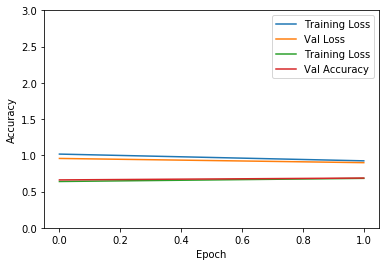

In [0]:
nepal_training_values, nepal_training_labels = ParseCSV_and_Create_Training_and_Labels('nepal.train', 'nepal_train.csv')
nepal_validation_values, nepal_validation_labels = ParseCSV_and_Create_Training_and_Labels('nepal.dev', 'nepal_dev.csv')
nepal_test_values, nepal_test_labels = ParseCSV_and_Create_Training_and_Labels('nepal.test', 'nepal_test.csv')


nepal_resized_Training_Values = Resize_Images(nepal_training_values)
nepal_resized_Validation_Values = Resize_Images(nepal_validation_values)

validation_dataset = (nepal_resized_Validation_Values, nepal_validation_labels.astype(float))

nepal_model = Create_VGG16Model()
nepal_model.summary()

#Fitting Nepal Model
nepal_model.compile(tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])
nepal_history = nepal_model.fit(nepal_resized_Training_Values, nepal_training_labels.astype(float), validation_data= validation_dataset, epochs = 2)

# Predicting on the test set
nepal_resized_test_values = Resize_Test_Images(nepal_test_values)
nepal_predictions = ruby_model.predict(nepal_resized_test_values)
nepal_predicted_labels = Extract_Predicted_Test_Labels(nepal_predictions)

nepal_test_labels = nepal_test_labels.astype(int)
nepal_value_predictions = np.equal(nepal_predicted_labels, nepal_test_labels)
nepal_correct_predictions = 0
for i in nepal_value_predictions:
    if(i == True):
        nepal_correct_predictions = nepal_correct_predictions + 1

nepal_accuracy = (nepal_correct_predictions/ len(nepal_predicted_labels)) * 100
print(nepal_accuracy)

mat = tf.math.confusion_matrix(nepal_test_labels, nepal_predicted_labels)
precision = Compute_Precision(mat.numpy())
recall = Compute_Recall(mat.numpy())
F1Score = Compute_F1Score(precision, recall)

print(precision)
print(recall)
print(F1Score)

plot_history(nepal_history)

55.46218487394958
[0.69230768 0.         0.14772727]
[0.67499999 0.         0.72222218]
None


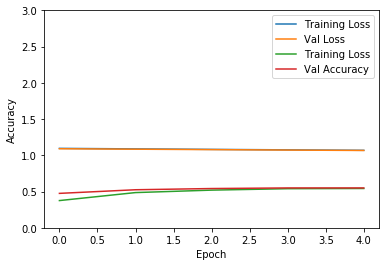

In [0]:
matthew_training_values, matthew_training_labels = ParseCSV_and_Create_Training_and_Labels('matthew.train', 'matthew_train.csv')
matthew_validation_values, matthew_validation_labels = ParseCSV_and_Create_Training_and_Labels('matthew.dev', 'matthew_dev.csv')
matthew_test_values, matthew_test_labels = ParseCSV_and_Create_Training_and_Labels('matthew.test', 'matthew_test.csv')

bad_labels = []
for i, v in enumerate(matthew_training_values):
  if(v == 'matthew_hurricane/matthew_hurricane_unlabelled_im_10.png' or v == 'matthew_hurricane/matthew_hurricane_unlabelled_im_218.png' or v == 'matthew_hurricane/matthew_hurricane_unlabelled_im_577.png'):
    bad_labels.append(i)

matthew_training_labels = np.delete(matthew_training_labels, bad_labels)

matthew_resized_Training_Values = Resize_Images(matthew_training_values)
matthew_resized_Validation_Values = Resize_Images(matthew_validation_values)

validation_dataset = (matthew_resized_Validation_Values, matthew_validation_labels.astype(float))

matthew_model = Create_VGG16Model()
matthew_model.summary()

# Fitting Matthew Model
matthew_model.compile(tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])
matthew_history = matthew_model.fit(matthew_resized_Training_Values, matthew_training_labels.astype(float), validation_data= validation_dataset, epochs = 5)

# Predicting on the test set
matthew_resized_test_values = Resize_Test_Images(matthew_test_values)
matthew_predictions = matthew_model.predict(matthew_resized_test_values)
matthew_predicted_labels = Extract_Predicted_Test_Labels(matthew_predictions)

matthew_test_labels = matthew_test_labels.astype(int)
matthew_value_predictions = np.equal(matthew_predicted_labels, matthew_test_labels)
matthew_correct_predictions = 0
for i in matthew_value_predictions:
    if(i == True):
        matthew_correct_predictions = matthew_correct_predictions + 1

# matthew_accuracy = (matthew_correct_predictions/ len(matthew_predicted_labels)) * 100
print(matthew_accuracy)

mat = tf.math.confusion_matrix(matthew_test_labels, matthew_predicted_labels)
precision = Compute_Precision(mat.numpy())
recall = Compute_Recall(mat.numpy())
F1Score = Compute_F1Score(precision, recall)

print(precision)
print(recall)
print(F1Score)

plot_history(matthew_history)

185.5421686746988
[0.69230768 0.         0.14772727]
[0.67499999 0.         0.72222218]
None


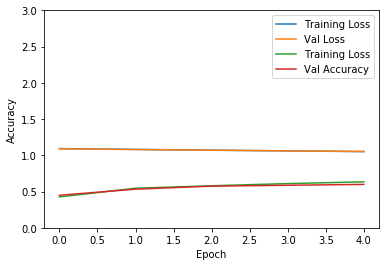

In [0]:
ruby_training_values, ruby_training_labels = ParseCSV_and_Create_Training_and_Labels('ruby.train', 'ruby_train.csv')
ruby_validation_values, ruby_validation_labels = ParseCSV_and_Create_Training_and_Labels('ruby.dev', 'ruby_dev.csv')
ruby_test_values, ruby_test_labels = ParseCSV_and_Create_Training_and_Labels('ruby.test', 'ruby_test.csv')


ruby_resized_Training_Values = Resize_Images(ruby_training_values)
ruby_resized_Validation_Values = Resize_Images(ruby_validation_values)

validation_dataset = (ruby_resized_Validation_Values, ruby_validation_labels.astype(float))

ruby_model = Create_VGG16Model()
ruby_model.summary()

# Fitting Ruby Model
ruby_model.compile(tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])
ruby_history = ruby_model.fit(ruby_resized_Training_Values, ruby_training_labels.astype(float), validation_data= validation_dataset, epochs = 5)

# Predicting on the test set

ruby_resized_test_values = Resize_Test_Images(ruby_test_values)
ruby_predictions = ruby_model.predict(ruby_resized_test_values)
ruby_predicted_labels = Extract_Predicted_Test_Labels(ruby_predictions)

ruby_test_labels = ruby_test_labels.astype(int)
ruby_value_predictions = np.equal(ruby_predicted_labels, ruby_test_labels)
ruby_correct_predictions = 0
for i in value_predictions:
    if(i == True):
        ruby_correct_predictions = ruby_correct_predictions + 1

ruby_accuracy = (ruby_correct_predictions/ len(ruby_predicted_labels)) * 100
print(ruby_accuracy)

mat = tf.math.confusion_matrix(ruby_test_labels, ruby_predicted_labels)
precision = Compute_Precision(mat.numpy())
recall = Compute_Recall(mat.numpy())
F1Score = Compute_F1Score(precision, recall)

print(precision)
print(recall)
print(F1Score)

plot_history(ruby_history)

66.00877192982456
[0.69230768 0.         0.14772727]
[0.67499999 0.         0.72222218]
None


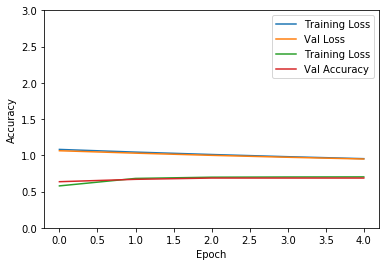

In [0]:
ecuador_training_values, ecuador_training_labels = ParseCSV_and_Create_Training_and_Labels('ecuador.train', 'ecuador_train.csv')
ecuador_validation_values, ecuador_validation_labels = ParseCSV_and_Create_Training_and_Labels('ecuador.dev', 'ecuador_dev.csv')
ecuador_test_values, ecuador_test_labels = ParseCSV_and_Create_Training_and_Labels('ecuador.test', 'ecuador_test.csv')


ecuador_resized_Training_Values = Resize_Images(ecuador_training_values)
ecuador_resized_Validation_Values = Resize_Images(ecuador_validation_values)

validation_dataset = (ecuador_resized_Validation_Values, ecuador_validation_labels.astype(float))

ecuador_model = Create_VGG16Model()
ecuador_model.summary()

# Fitting Ecuador Model
ecuador_model.compile(tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])
ecuador_history = ecuador_model.fit(ecuador_resized_Training_Values, ecuador_training_labels.astype(float), validation_data= validation_dataset, epochs = 5)

# Predicting on the test set
ecuador_resized_test_values = Resize_Test_Images(ecuador_test_values)
ecuador_predictions = ecuador_model.predict(ecuador_resized_test_values)
ecuador_predicted_labels = Extract_Predicted_Test_Labels(ecuador_predictions)

ecuador_test_labels = ecuador_test_labels.astype(int)
ecuador_value_predictions = np.equal(ecuador_predicted_labels, ecuador_test_labels)
ecuador_correct_predictions = 0
for i in ecuador_value_predictions:
    if(i == True):
        ecuador_correct_predictions = ecuador_correct_predictions + 1

ecuador_accuracy = (ecuador_correct_predictions/ len(ecuador_predicted_labels)) * 100
print(ecuador_accuracy)

mat = tf.math.confusion_matrix(ecuador_test_labels, ecuador_predicted_labels)
precision = Compute_Precision(mat.numpy())
recall = Compute_Recall(mat.numpy())
F1Score = Compute_F1Score(precision, recall)

print(precision)
print(recall)
print(F1Score)

plot_history(ecuador_history)

In [0]:
#Creating Noisy Student Model

# Creating a combined test value set
combined_training_values = np.row_stack((matthew_resized_Training_Values, ruby_resized_Training_Values, ecuador_resized_Training_Values, nepal_resized_Training_Values))

# Creating a combined label set
combined_training_labels = np.concatenate((matthew_training_labels, ruby_training_labels, ecuador_training_labels, nepal_training_labels))

# Creating a new VGG16 Model
combined_model = Create_VGG16Model()

combined_model.compile(tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])

matthew_hurricane/matthew_hurricane_unlabelled_im_10.png
matthew_hurricane/matthew_hurricane_unlabelled_im_218.png
matthew_hurricane/matthew_hurricane_unlabelled_im_577.png


KeyboardInterrupt: 

In [0]:
# Creating the teacher model by training on the combined dataset
combined_history = combined_model.fit(combined_training_values, combined_training_labels.astype(float), epochs = 1)

!wget https://crisisnlp.qcri.org/data/crisismmd/CrisisMMD_v1.0.tar.gz
!tar -xf CrisisMMD_v1.0.tar.gz

Train on 13685 samples
13685/13685 [==============================] - 1247s 91ms/sample - loss: 0.9825 - accuracy: 0.6533
--2019-12-01 20:03:11--  https://crisisnlp.qcri.org/data/crisismmd/CrisisMMD_v1.0.tar.gz
Resolving crisisnlp.qcri.org (crisisnlp.qcri.org)... 80.76.166.234
Connecting to crisisnlp.qcri.org (crisisnlp.qcri.org)|80.76.166.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1901224486 (1.8G) [application/x-gzip]
Saving to: ‘CrisisMMD_v1.0.tar.gz.2’

CrisisMMD_v1.0.tar. 100%[===================>]   1.77G  8.70MB/s    in 4m 55s  

2019-12-01 20:08:08 (6.15 MB/s) - ‘CrisisMMD_v1.0.tar.gz.2’ saved [1901224486/1901224486]



In [0]:
def Resize_Unlabeled_Images():
  image_list = []
  for filename in glob.glob('/home/rstewar2/Documents/CIS890-Deep-Learning/CrisisMMD_v1.0/data_image/*/*/*.jpg'): 
      img = Image.open(filename)
      resized_img = np.array(img.resize((224, 224)))
      if(resized_img.shape == (224, 224, 3) and len(image_list) < 4000):
        image_list.append(resized_img)
      else:
        break
  return np.array(image_list, float), np.array(image_list)

float_images, int_images = Resize_Unlabeled_Images()

(4000, 224, 224, 3)

In [0]:
# Using the trained teacher model to predict on unlabeled images

combined_model_predict_history = combined_model.predict(float_images)

# Extracting the labels from the predictions
psuedo_predictions = []
for i in combined_model_predict_history:
    psuedo_predictions.append(np.argmax(i))
    
# Creating combined training values including the training values for the unlabeled images
combined_training_values = np.row_stack((matthew_resized_Training_Values, ruby_resized_Training_Values, ecuador_resized_Training_Values, int_images))


# Creating the training labels including the training labels predicted by the teacher model
combined_training_labels = np.concatenate((matthew_training_labels, ruby_training_labels, ecuador_training_labels, psuedo_predictions))


# Creating the Student model
student_combined_model = Create_VGG16Model()

student_combined_model.compile(tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])
# Training the Student model on the combined dataset creating from training the teacher model
student_combined_model_history  = student_combined_model.fit(combined_training_values, combined_training_labels.astype(float), epochs = 1)

In [0]:

# # Creating the Student model
# student_combined_model = Create_VGG16Model()

# student_combined_model.compile(tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])
# # Training the Student model on the combined dataset creating from training the teacher model
# student_combined_model_history  = student_combined_model.fit(combined_training_values, combined_training_labels.astype(float), epochs = 1)

Train on 6222 samples
6222/6222 [==============================] - 574s 92ms/sample - loss: 1.0254 - accuracy: 0.7014


In [0]:
# Predicting on the Ecuador Dataset using the Student model
student_combined_model_predictions = student_combined_model.predict(ecuador_resized_test_values)
student_combined_model_predicted_labels = Extract_Predicted_Test_Labels(student_combined_model_predictions)

student_combined_model_test_labels = ecuador_test_labels #student_combined_model_test_labels.astype(int)
student_combined_model_value_predictions = np.equal(student_combined_model_predicted_labels, student_combined_model_test_labels)
student_combined_model_correct_predictions = 0
for i in student_combined_model_value_predictions:
    if(i == True):
        student_combined_model_correct_predictions = student_combined_model_correct_predictions + 1

student_combined_model_accuracy = (student_combined_model_correct_predictions/ len(student_combined_model_predicted_labels)) * 100

mat = tf.math.confusion_matrix(student_combined_model_test_labels, student_combined_model_predicted_labels)
precision = Compute_Precision(mat.numpy())
recall = Compute_Recall(mat.numpy())
F1Score = Compute_F1Score(precision, recall)

print(student_combined_model_accuracy)

print(precision)
print(recall)
print(F1Score)

Precision for class: 0 0.6699029093694033
Precision for class: 1 0.0
Precision for class: 2 0.775999996896
Recall for class: 0 0.7582417540755948
Recall for class: 1 0.0
Recall for class: 2 0.7854250980347162
F1 Score for Class 0 0.7113397044322757
F1 Score for Class 1 0.0
F1 Score for Class 2 0.7806836015047189
72.80701754385966
[0.66990291 0.         0.776     ]
[0.75824175 0.         0.7854251 ]
None


In [0]:
# Predicting on the Nepal Dataset using the Student model
student_combined_model_predictions = student_combined_model.predict(nepal_resized_test_values)
student_combined_model_predicted_labels = Extract_Predicted_Test_Labels(student_combined_model_predictions)

student_combined_model_test_labels = nepal_test_labels #student_combined_model_test_labels.astype(int)
student_combined_model_value_predictions = np.equal(student_combined_model_predicted_labels, student_combined_model_test_labels)
student_combined_model_correct_predictions = 0
for i in student_combined_model_value_predictions:
    if(i == True):
        student_combined_model_correct_predictions = student_combined_model_correct_predictions + 1

student_combined_model_accuracy = (student_combined_model_correct_predictions/ len(student_combined_model_predicted_labels)) * 100
print(student_combined_model_accuracy)

mat = tf.math.confusion_matrix(student_combined_model_test_labels, student_combined_model_predicted_labels)
precision = Compute_Precision(mat.numpy())
recall = Compute_Recall(mat.numpy())
F1Score = Compute_F1Score(precision, recall)

print(precision)
print(recall)
print(F1Score)

62.82722513089005
Precision for class: 0 0.646710525890322
Precision for class: 1 0.0
Precision for class: 2 0.6160869562538752
Recall for class: 0 0.6205808076890272
Recall for class: 1 0.0
Recall for class: 2 0.7938375345692786
F1 Score for Class 0 0.6333757884646474
F1 Score for Class 1 0.0
F1 Score for Class 2 0.6937571575464359
[0.64671053 0.         0.61608696]
[0.62058081 0.         0.79383753]
None


In [0]:
# Predicting on the Matthew Dataset using the Student model
student_combined_model_predictions = student_combined_model.predict(matthew_resized_test_values)
student_combined_model_predicted_labels = Extract_Predicted_Test_Labels(student_combined_model_predictions)

student_combined_model_test_labels = matthew_test_labels #student_combined_model_test_labels.astype(int)
student_combined_model_value_predictions = np.equal(student_combined_model_predicted_labels, student_combined_model_test_labels)
student_combined_model_correct_predictions = 0
for i in student_combined_model_value_predictions:
    if(i == True):
        student_combined_model_correct_predictions = student_combined_model_correct_predictions + 1

student_combined_model_accuracy = (student_combined_model_correct_predictions/ len(student_combined_model_predicted_labels)) * 100
print(student_combined_model_accuracy)

mat = tf.math.confusion_matrix(student_combined_model_test_labels, student_combined_model_predicted_labels)
precision = Compute_Precision(mat.numpy())
recall = Compute_Recall(mat.numpy())
F1Score = Compute_F1Score(precision, recall)

print(precision)
print(recall)
print(F1Score)

42.016806722689076
Precision for class: 0 0.7837837626004389
Precision for class: 1 0.0
Precision for class: 2 0.2560975578524688
Recall for class: 0 0.44615383928994096
Recall for class: 1 0.0
Recall for class: 2 0.8076922766272201
F1 Score for Class 0 0.5686269775090252
F1 Score for Class 1 0.0
F1 Score for Class 2 0.38888851611830866
[0.78378376 0.         0.25609756]
[0.44615384 0.         0.80769228]
None


In [0]:
# Predicting on the Ruby Dataset using the Student model
student_combined_model_predictions = student_combined_model.predict(ruby_resized_test_values)
student_combined_model_predicted_labels = Extract_Predicted_Test_Labels(student_combined_model_predictions)

student_combined_model_test_labels = ruby_test_labels #student_combined_model_test_labels.astype(int)
student_combined_model_value_predictions = np.equal(student_combined_model_predicted_labels, student_combined_model_test_labels)
student_combined_model_correct_predictions = 0
for i in student_combined_model_value_predictions:
    if(i == True):
        student_combined_model_correct_predictions = student_combined_model_correct_predictions + 1

student_combined_model_accuracy = (student_combined_model_correct_predictions/ len(student_combined_model_predicted_labels)) * 100
print(student_combined_model_accuracy)

mat = tf.math.confusion_matrix(student_combined_model_test_labels, student_combined_model_predicted_labels)
precision = Compute_Precision(mat.numpy())
recall = Compute_Recall(mat.numpy())
F1Score = Compute_F1Score(precision, recall)

print(precision)
print(recall)
print(F1Score)

40.36144578313253
Precision for class: 0 0.6923076834319528
Precision for class: 1 0.0
Precision for class: 2 0.14772727104855374
Recall for class: 0 0.6749999915625001
Recall for class: 1 0.0
Recall for class: 2 0.7222221820987677
F1 Score for Class 0 0.6835437952254899
F1 Score for Class 1 0.0
F1 Score for Class 2 0.24528273228938677
[0.69230768 0.         0.14772727]
[0.67499999 0.         0.72222218]
None
